#CafChem tools for training classification models.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/Classifiers_CafChem.ipynb)

## This notebook allows you to:
- Load a CSV and create classes out of quantitative data
- Train tree, ridge, support vecotr machines, logistic regression, and MLP-based classification models.
- Analyze data.
- Serve Predictions


## Requirements:
- This notebook will install RDKit
- It will pull the CafChem tools from Github.
- It will install all needed libraries.
- Can run on a CPU.

## Set-up

### install RDKit

In [1]:
! pip install deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 35.2 MB/s eta 0:00:00


### Pull the CafChem library from Github and install other libraries

In [2]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 375 (delta 95), reused 40 (delta 40), pack-reused 259 (from 2)
Receiving objects: 100% (375/375), 2.91 MiB | 4.28 MiB/s, done.
Resolving deltas: 100% (206/206), done.


In [14]:
import pandas as pd
import pickle as pkl
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt
import CafChem.CafChemClassifiers as ccc

## Load CSV files and create classes
- the make_classes tool takes a CSV with a numerical target and creates the indicated number of classes
- returns a new dataframe with the classes added

In [4]:
df = ccc.make_classes("/content/905-unique-statins.csv","IC50 (nM)",3)

Samples per class: 301, total samples:905


In [6]:
df.head()

,Unnamed: 0,Ligand SMILES,IC50 (nM),class labels
0,7,CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])=O)c(c...,0.106,0.106 < 15.0
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200,0.106 < 15.0
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300,0.106 < 15.0
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300,0.106 < 15.0
4,12,COC(=O)C[C@H](O)C[C@H](O)\C=C\n1c(C(C)C)c(Br)c...,0.300,0.106 < 15.0


In [7]:
df.to_csv("905_statins_3classes.csv")

## Featurize data and create datasets
- Featurize with RDKit, fingerprints or Mordred
- apply scaling, PCA (optional) and split into training and validation sets

In [5]:
smiles = df["Ligand SMILES"].to_list()
y = df["class labels"].to_list()

In [6]:
f, y, smiles = ccc.featurize(smiles, y, featurizer = "rdkit")

Old dimensions are: (905, 217).
New dimensions are: (905, 217)


In [7]:
x_train, x_valid, y_train, y_valid, smiles_train, smiles_valid, pca, scaler = ccc.scale_pca_split(f, y, smiles, use_scaler = True, use_pca = False, pca_size = 100)

Pre-processing done.


## Create a logistic regression classifier
- choose li, l2 or elasticnet penalties
- the variable l1_ration needed for elasticnet

In [11]:
logreg = ccc.LogReg_methods(penalty = "elasticnet", C = 10.0, l1_ratio=0.2)

Logistic Regression (classification) class initialized.


In [14]:
lg = logreg.fit(x_train, x_valid, y_train, y_valid)

model selected:  LogisticRegression
fit model in: 0.4992245808333327 minutes
score for training set:  0.8587223587223587
score for validation set:  0.7252747252747253


## Perform Hyperparameter optimization

In [119]:
penalties = ["elasticnet"]
l1_ratios = [0.2,0.5,0.8]
Cs = [0.01,0.1,1.0,10.0,100.0]

for penalty in penalties:
  print(f"Penalty: {penalty}")
  for C in Cs:
    print(f"C: {C}")
    for l1_ratio in l1_ratios:
      print(f"L1 ratio: {l1_ratio}")
      logreg = LogReg_methods(penalty = penalty, C = C, l1_ratio = l1_ratio)
      logreg.fit(x_train, x_valid, y_train, y_valid)

Penalty: elasticnet
C: 0.01
L1 ratio: 0.2
Logistic Regression (classification) class initialized.
model selected:  LogisticRegression
fit model in: 0.03218767871667296 minutes
score for training set:  0.45085995085995084
score for validation set:  0.34065934065934067
L1 ratio: 0.5
Logistic Regression (classification) class initialized.
model selected:  LogisticRegression
fit model in: 0.03460624668332457 minutes
score for training set:  0.36363636363636365
score for validation set:  0.34065934065934067
L1 ratio: 0.8
Logistic Regression (classification) class initialized.
model selected:  LogisticRegression
fit model in: 0.02253502258336084 minutes
score for training set:  0.3083538083538084
score for validation set:  0.3626373626373626
C: 0.1
L1 ratio: 0.2
Logistic Regression (classification) class initialized.
model selected:  LogisticRegression
fit model in: 0.09556091616665678 minutes
score for training set:  0.5921375921375921
score for validation set:  0.37362637362637363
L1 ratio

## Train a tree-based classification model
- decision tree, random forest, or gradient-boosting

In [16]:
rand = ccc.tree_classification(method = "forest", n_estimators = 300, max_depth = None,
               min_samples_split = 2, min_samples_leaf = 1, max_features = 1.0)
rf = rand.fit(x_train, x_valid, y_train, y_valid)

Tree classification class initialized.
model selected:  RandomForest
fit model in: 0.2684898961999996 minutes
score for training set:  0.9914004914004914
score for validation set:  0.7362637362637363


## Train a Ridge or Support Vector Machines classifier

In [18]:
svm = ccc.ridge_svm_methods(method = "svm", degree = 3, C = 2.0, coef0 = 2.0)
svm_model = svm.fit(x_train, x_valid, y_train, y_valid)

Ridge SVM class initialized.
model selected:  Support Vector Machines
fit model in: 0.0015447832999996081 minutes
score for training set:  0.9152334152334153
score for validation set:  0.7362637362637363


In [19]:
ridge = ccc.ridge_svm_methods(method = "ridge", alpha=100)
ridge_model = ridge.fit(x_train, x_valid, y_train, y_valid)

Ridge SVM class initialized.
model selected:  Ridge
fit model in: 0.00250030038333288 minutes
score for training set:  0.7788697788697788
score for validation set:  0.6923076923076923


## Train a Multilayer Perceptron classifier

In [8]:
mlp = ccc.mlp_methods(solver = "adam", seed = 42, hidden_layer_sizes = [50,50],
               max_iter = 2000, activation = "relu", alpha = 0.1)
mlp_model = mlp.fit(x_train, x_valid, y_train, y_valid)

MLP class initialized.
model selected:  MultiLayerPerceptron
fit model in: 0.035997498049999875 minutes
score for training set:  0.9594594594594594
score for validation set:  0.7142857142857143


## Visualize classification model results with a confusion matrix

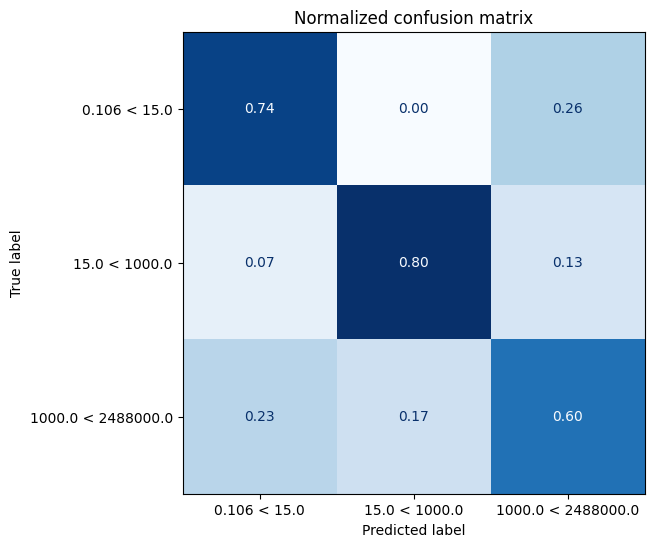

In [9]:
conf = ccc.evaluate(mlp_model, df["class labels"].unique(), x_valid, y_valid)
conf.confusion()

## Use a model to predict new values
- the predict_with_model tool takes a list of SMILES to analyze, a model to use, the featurizer used, and a scaler and pca (optional).
- If you have ground truth for these values, you can use the analyze_predictions tool to compare the predictions and the truths.

In [10]:
'''
This code creates a sample predicting set from the trainig data, you should use an actual prediction set
'''
random_indicies = np.random.randint(0,len(df),20)

test_smiles = []
test_ic50s = []
for i in random_indicies:
  test_smiles.append(df["Ligand SMILES"].iloc[i])
  test_ic50s.append(df["IC50 (nM)"].iloc[i])

In [11]:
preds = ccc.predict_with_model(test_smiles, mlp_model, featurizer = "rdkit", scaler = scaler)

In [12]:
ccc.analyze_predictions(preds, test_ic50s)

Predicted: 1000.0 < 2488000.0  , Truth:   12000.00, prediction is correct
Predicted: 15.0 < 1000.0       , Truth:     360.00, prediction is correct
Predicted: 1000.0 < 2488000.0  , Truth:  200000.00, prediction is correct
Predicted: 0.106 < 15.0        , Truth:       7.20, prediction is correct
Predicted: 0.106 < 15.0        , Truth:       1.20, prediction is correct
Predicted: 1000.0 < 2488000.0  , Truth:    6310.00, prediction is correct
Predicted: 0.106 < 15.0        , Truth:       4.10, prediction is correct
Predicted: 0.106 < 15.0        , Truth:       2.20, prediction is correct
Predicted: 15.0 < 1000.0       , Truth:      37.00, prediction is correct
Predicted: 0.106 < 15.0        , Truth:       1.80, prediction is correct
Predicted: 15.0 < 1000.0       , Truth:      19.00, prediction is correct
Predicted: 15.0 < 1000.0       , Truth:      30.00, prediction is correct
Predicted: 15.0 < 1000.0       , Truth:      16.00, prediction is correct
Predicted: 15.0 < 1000.0       , Truth

## Save models, CSV files, predictions

In [16]:
with open('mlp_model.pkl','wb') as model_file:
  pkl.dump(mlp_model, model_file)

with open('scaler.pkl','wb') as scaler_file:
  pkl.dump(scaler, scaler_file)

with open('pca.pkl','wb') as pca_file:
  pkl.dump(pca, pca_file)

In [18]:
y_to_save = np.concatenate((y_train,y_valid))

predictions = mlp_model.predict(f)

smiles_to_save = np.concatenate((smiles_train,smiles_valid))

save_dict = {"SMILES": smiles_to_save, "truth_labels": y_to_save, "Predictions": predictions}
df_to_save = pd.DataFrame(save_dict)
df_to_save.to_csv("mlp_predictions.csv")

## Load a model

In [19]:
with open('mlp_model.pkl','rb') as model_file:
  loaded_model = pkl.load(model_file)

with open('scaler.pkl','rb') as scaler_file:
  loaded_scaler = pkl.load(scaler_file)

with open('pca.pkl','rb') as pca_file:
  loaded_pca = pkl.load(pca_file)